In [1]:
from typing import Dict, Any, Tuple, List

import torch
import torch.nn as nn
from configs import config
from torch.nn import functional as F
from model import SparseSegNet, SSCHead, MyModel
import MinkowskiEngine as Me
from semantic_kitti_dataset import SemanticKITTIDataset, Merge
from tqdm import tqdm
import numpy as np
import time
from structures import collect
from evaluation import iouEval
import k3d
import numpy as np
from utils import plot_3d_voxels, plot_2d_input, plot_bev, plot_3d_pointcloud
from model import VoxelPooling
device = torch.device("cuda:0")

shapes = {"256": torch.Size([1, 1, 256, 256, 32]), "128": torch.Size([1, 1, 128, 128, 16]), "64": torch.Size([1, 1, 64, 64, 8])}

%load_ext autoreload
%autoreload 2


In [2]:
# import matplotlib.pyplot as plt
# translation = (np.random.normal(size=10000))*0.04

# fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# # We can set the number of bins with the *bins* keyword argument.
# axs[0].hist(translation, bins=1000)


In [3]:
# Color map for lidar intensities
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
def rgb_to_hex(rgb):
    rgb = totuple(rgb)
    return '0x%02x%02x%02x' % rgb
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('plasma', 20)
cmap = []
for rgb in (np.uint8((viridis.colors)[:,:-1]*255.0)):
    hex_str = rgb_to_hex(rgb)
    hex_int = int(hex_str, 16)
    new_int = hex_int + 0x200
    cmap.append(new_int)

classes_colors = [
    # [245, 150, 100],
    [245, 230, 100],
    [150, 60, 30],
    [180, 30, 80],
    [255, 0, 0],
    [30, 30, 255],
    [200, 40, 255],
    [90, 30, 150],
    [255, 0, 255],
    [255, 150, 255],
    [75, 0, 75],
    [75, 0, 175],
    [0, 200, 255],
    [50, 120, 255],
    [0, 175, 0],
    [0, 60, 135],
    [80, 240, 150],
    [150, 240, 255],
    [0, 0, 255],
    [255, 255, 50]]
print(len(classes_colors))
classes_cmap = []
for rgb in (np.uint8(classes_colors)):
    hex_str = rgb_to_hex(rgb)
    hex_int = int(hex_str, 16)
    new_int = hex_int + 0x200
    classes_cmap.append(new_int)

color_map = np.array([
    [245, 150, 100],
    [245, 230, 100],
    [150, 60, 30],
    [180, 30, 80],
    [255, 0, 0],
    [30, 30, 255],
    [200, 40, 255],
    [90, 30, 150],
    [255, 0, 255],
    [255, 150, 255],
    [75, 0, 75],
    [75, 0, 175],
    [0, 200, 255],
    [50, 120, 255],
    [0, 175, 0],
    [0, 60, 135],
    [80, 240, 150],
    [150, 240, 255],
    [0, 0, 255],
    [255, 255, 50]])
color_map = np.float32(color_map)/255.0

19


/tmp/ipykernel_5041/1472938767.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('plasma', 20)


## Dataloader

In [4]:
config.GENERAL.NUM_SAMPLES_OVERFIT = 1
config.GENERAL.OVERFIT = True
config.TRAIN.AUGMENT = False
config.TRAIN.NOISE_LEVEL = 0.0
config.TRAIN.NUM_WORKERS = 0
config.TRAIN.BATCH_SIZE = 1

train_dataset = SemanticKITTIDataset("train",do_overfit=config.GENERAL.OVERFIT, num_samples_overfit=config.GENERAL.NUM_SAMPLES_OVERFIT, augment=config.TRAIN.AUGMENT)
train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN.BATCH_SIZE,
        collate_fn=Merge,
        num_workers=config.TRAIN.NUM_WORKERS,
        pin_memory=True,
        shuffle=False,
        drop_last=True,
        worker_init_fn=lambda x: np.random.seed(x + int(time.time()))
    )
print(len(train_data_loader))

1


In [5]:
batch = next(iter(train_data_loader))
_, complet_inputs, _, _ = batch


In [6]:
seg_coords = collect(complet_inputs, "seg_coords")

seg_labels = collect(complet_inputs, "seg_labels")
seg_features = collect(complet_inputs, "seg_features")
print(seg_coords.shape)
print(seg_labels.shape)
print(seg_features.shape)


print(torch.unique(seg_labels))

sparse_segnet = SparseSegNet().cuda()
pytorch_total_params = sum(p.numel() for p in sparse_segnet.parameters() if p.requires_grad)
print("Total params: ", pytorch_total_params)
sparse_segnet.eval()
with torch.no_grad():
    start = time.time()
    output, feat, loss = sparse_segnet(seg_coords, seg_features, seg_labels)
    end = time.time()
    print("time: ", end-start)
print("output:",output.shape)

torch.Size([124668, 4])
torch.Size([124668])
torch.Size([124668, 4])
tensor([-100.,    0.,    7.,    8.,    9.,   10.,   12.,   13.,   14.,   15.,
          16.,   17.,   18.], device='cuda:0')
Total params:  2106739


/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:295: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  warnings.warn(


time:  0.37422752380371094
output: torch.Size([124668, 19])


## Voxelize feature vector to pass it as input to completion network

In [7]:
complet_features = collect(complet_inputs, "complet_features").transpose(0,1)
coords = collect(complet_inputs, "complet_coords")
print("coords: ", coords.shape)
print("how features should look: ",complet_features.shape)
complet_invoxel_features = collect(complet_inputs, "complet_invoxel_features")
voxel_centers = collect(complet_inputs, "voxel_centers")
print("invoxel: ", complet_invoxel_features[:,:,:-1].shape)
print("invoxel: ", complet_invoxel_features[:,:,-2].shape)
print("voxel_centers: ", voxel_centers.shape)

feeding = torch.cat([output,feat],dim=1)
print(feeding.shape)
voxelpool = VoxelPooling()

dummy_seg_features = collect(complet_inputs, "seg_features")[:,-1].unsqueeze(1)
print("dummy: ", dummy_seg_features.shape)

start = time.time()
seg_features = voxelpool(invoxel_xyz=complet_invoxel_features[:, :, :-1],
                     invoxel_map=complet_invoxel_features[:, :, 3].long(),
                     src_feat=feeding,
                     voxel_center=voxel_centers)
end = time.time()
print("time: ", end-start)
print("features: ", seg_features.shape)




# Check pooling




coords:  torch.Size([1, 11713, 4])
how features should look:  torch.Size([11713, 1])
invoxel:  torch.Size([11713, 20, 7])
invoxel:  torch.Size([11713, 20])
voxel_centers:  torch.Size([11713, 3])
torch.Size([124668, 35])
dummy:  torch.Size([124668, 1])
time:  0.0007097721099853516
features:  torch.Size([11713, 35])


In [8]:
# Uncertainty loss
seg_sigma = nn.Parameter(torch.Tensor(1).uniform_(0.2, 1), requires_grad=True)
print(seg_sigma)


Parameter containing:
tensor([0.4060], requires_grad=True)


## Pass to completion model

In [9]:
config.MODEL.NUM_INPUT_FEATURES  = 16
config.MODEL.NUM_OUTPUT_CHANNELS  = 16
ssc_net = SSCHead(num_output_channels=config.MODEL.NUM_OUTPUT_CHANNELS, unet_features=config.MODEL.NUM_INPUT_FEATURES).to(device)
pytorch_total_params = sum(p.numel() for p in ssc_net.parameters() if p.requires_grad)
print("Total params: ", pytorch_total_params)
ssc_net.eval()
compl_labelweights = torch.Tensor(train_dataset.compl_labelweights).cuda()
with torch.no_grad():
    start = time.time()
    _,results = ssc_net(complet_inputs, seg_features, compl_labelweights)
    end = time.time()
    print("time: ",end-start)
    print(results.keys())

num_input_features: 16
Total params:  9022335
time:  0.14618730545043945
dict_keys(['occupancy_64', 'semantic_64'])


/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:537: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coords = coords // tensor_stride


## Complet Model

In [10]:
model = MyModel().cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load seg pretrained
seg_labelweights = torch.Tensor(train_dataset.seg_labelweights).cuda()
config.SEGMENTATION.CHECKPOINT = "/usr/src/app/semantic-scene-completion/experiments/008/modelFULL-9.pth"
model_seg_checkpoint = MyModel().cuda()
model_seg_checkpoint.load_state_dict(torch.load(config.SEGMENTATION.CHECKPOINT))
model.seg_model.load_state_dict(model_seg_checkpoint.seg_model.state_dict())
del model_seg_checkpoint

model.seg_model.requires_grad = False

print("Total params: ", pytorch_total_params)
model.eval()

with torch.no_grad():
    start = time.time()
    results, losses, _ = model(complet_inputs, seg_weights=seg_labelweights, compl_weights=compl_labelweights)
    end = time.time()
    print("time: ",end-start)
    print(results.keys())
    print(losses)


num_input_features: 16
num_input_features: 16
Total params:  11129256
time:  0.23242521286010742
dict_keys(['pc_seg', 'seg_feat', 'occupancy_64', 'semantic_64'])
{'pc_seg': tensor(0.3733, device='cuda:0'), 'occupancy_64': tensor(0.7763, device='cuda:0'), 'semantic_64': tensor(0.0641, device='cuda:0')}


## Visualize predictions from pretrained segmentation model

torch.Size([124668, 19])
torch.Size([124668])
torch.Size([124668, 3])
[ 0  2  3  4  5  7  8  9 10 12 13 14 15 16 17 18]


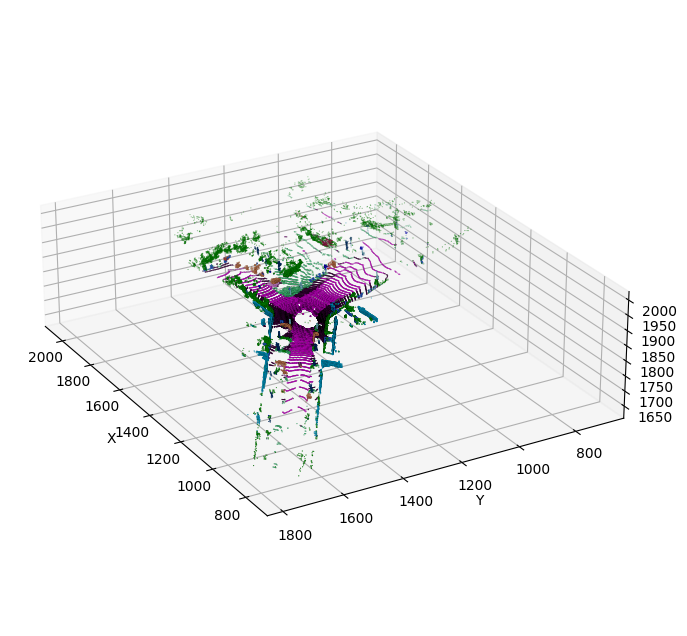



tensor([-0.1986, -0.1982, -0.1982,  ...,  0.1880,  0.1912,  0.1935],
       device='cuda:0')
pc_seg_pred_vox:  torch.Size([1, 11713])
tensor([ 0,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17], device='cuda:0')
(11713, 3)
(11713, 3)


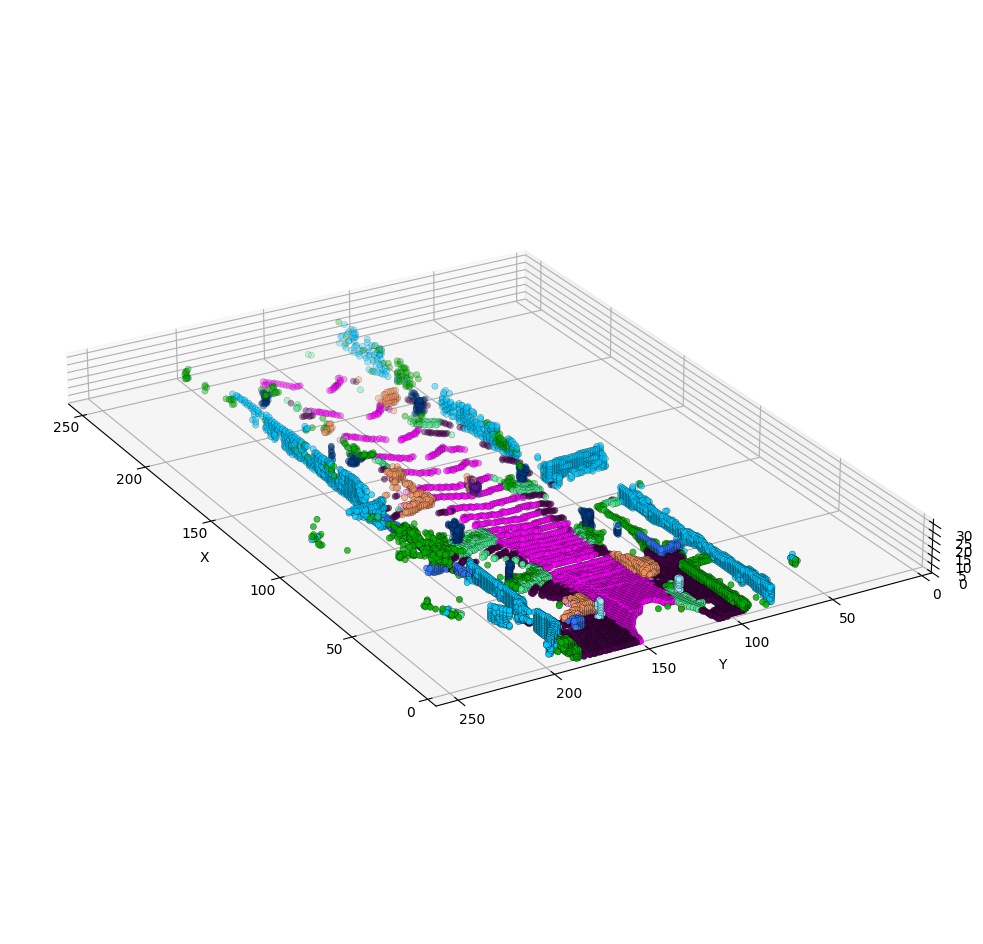

In [11]:
pc_seg = results['pc_seg']
print(pc_seg.shape)
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
print(pc_seg_pred.shape)

seg_coords = collect(complet_inputs, "seg_coords")[:,1:]
print(seg_coords.shape)

coords_np = seg_coords.detach().cpu().numpy()
plot_3d_pointcloud(seg_coords, pc_seg_pred)

# Voxelize
print("\n")
print(torch.unique(complet_invoxel_features[:, :, -2]))
voxelpool = VoxelPooling()
voxelpool.pooling_mode = 'max'
pc_seg_pred_vox = voxelpool(invoxel_xyz=complet_invoxel_features[:, :, :-1],
                     invoxel_map=complet_invoxel_features[:, :, 3].long(),
                     src_feat=pc_seg_pred.unsqueeze(1),
                     voxel_center=voxel_centers).transpose(0,1)
print("pc_seg_pred_vox: ", pc_seg_pred_vox.shape)
print(torch.unique(pc_seg_pred_vox))

coords = collect(complet_inputs, "complet_coords").cpu().numpy()[0,:,1:]
print(coords.shape)

coords_np = coords.astype(int)
print(coords_np.shape)
voxels = np.zeros((256,256,32))
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=(np.uint8(pc_seg_pred_vox.detach().cpu().numpy())+1)
plot_3d_voxels(voxels, "256", input=False)

    

torch.Size([11713, 35])
torch.Size([11713, 19])
torch.Size([11713])
(11713, 3)
(11713, 3)


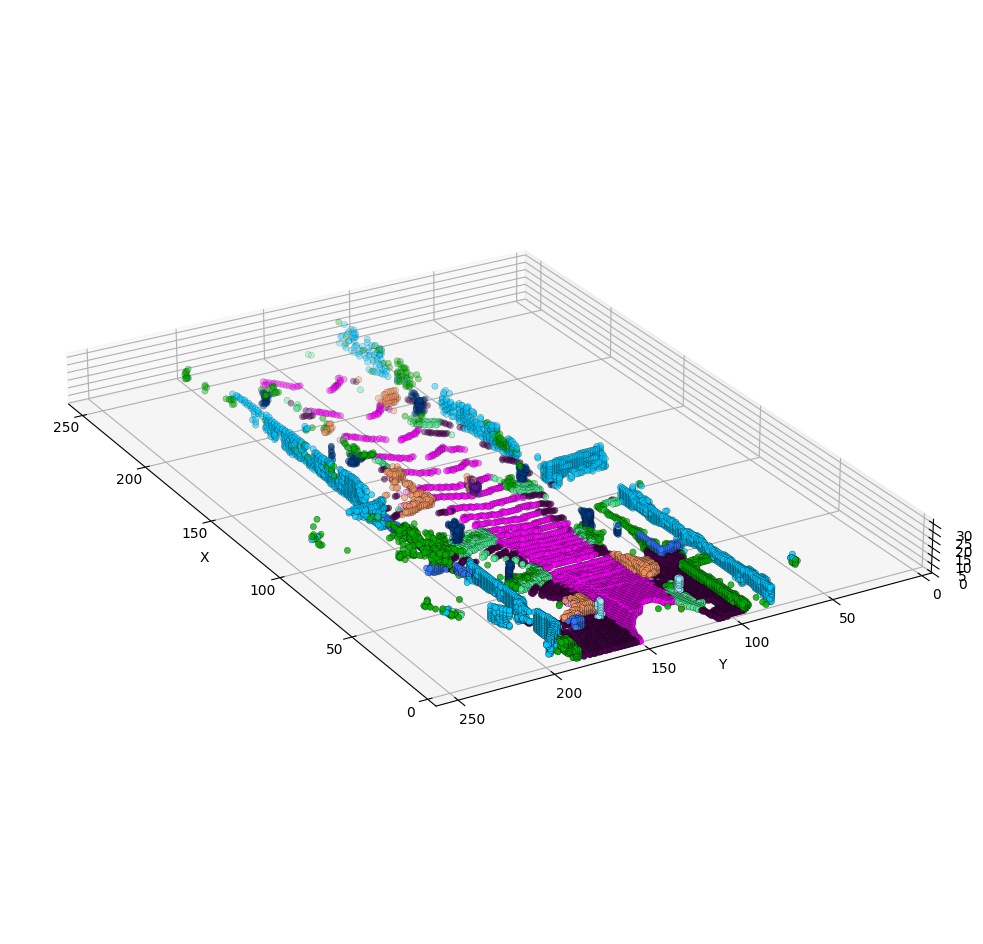

In [14]:
seg_feat = results['seg_feat']
print(seg_feat.shape)
pc_seg = seg_feat[:,:19]
print(pc_seg.shape)
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
print(pc_seg_pred.shape)


coords = collect(complet_inputs, "complet_coords").cpu().numpy()[0,:,1:]
print(coords.shape)

coords_np = coords.astype(int)
print(coords_np.shape)
voxels = np.zeros((256,256,32))
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=(np.uint8(pc_seg_pred_vox.detach().cpu().numpy())+1)
plot_3d_voxels(voxels, "256", input=False)

In [50]:

classes_colors = [
    [245, 150, 100],
    [245, 230, 100],
    [150, 60, 30],
    [180, 30, 80],
    [255, 0, 0],
    [30, 30, 255],
    [200, 40, 255],
    [90, 30, 150],
    [255, 0, 255],
    [255, 150, 255],
    [75, 0, 75],
    [75, 0, 175],
    [0, 200, 255],
    [50, 120, 255],
    [0, 175, 0],
    [0, 60, 135],
    [80, 240, 150],
    [150, 240, 255],
    [0, 0, 255],
    [255, 255, 50]]
print(len(classes_colors))
classes_cmap = []
for rgb in (np.uint8(classes_colors)):
    hex_str = rgb_to_hex(rgb)
    hex_int = int(hex_str, 16)
    new_int = hex_int + 0x200
    classes_cmap.append(new_int)

classes_cmap = np.array(classes_cmap)

import k3d
pc_seg = results['pc_seg']
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
seg_coords = collect(complet_inputs, "seg_coords")[:,1:]

# plot_3d_pointcloud(seg_coords[0],seg_labels[0])
seg_labels_np = np.uint32(pc_seg_pred.detach().cpu().numpy())
seg_coords_np = np.float32(seg_coords.detach().cpu().numpy())
print(seg_coords_np.shape)
print(seg_labels_np.shape)
seg_coords_np = seg_coords_np[seg_labels_np<100]
seg_labels_np = seg_labels_np[seg_labels_np<100]+1
print(seg_coords_np.shape)
print(seg_labels_np.shape)
print(np.unique(seg_labels_np))
plot = k3d.plot(camera_auto_fit=True)
colors = classes_cmap[np.uint8(seg_labels_np)]
plt_points = k3d.points(seg_coords_np, attribute=np.uint32(seg_labels_np),point_size=1,shader="dot",colors=colors)
plot += plt_points
plot.display()

20
(124668, 3)
(124668,)
(124668, 3)
(124668,)
[ 1  3  4  5  6  8  9 10 11 13 14 15 16 17 18 19]


Output()

## Visualize data

In [43]:
x = np.random.uniform(size=1000) < 0.1
print(np.sum(x))

111


In [10]:
batch = next(iter(train_data_loader))
_, complet_inputs, _, _ = batch
seg_coords = collect(complet_inputs, "seg_coords")
# print(torch.unique(seg_coords[:,0]))
# print(torch.unique(seg_coords[:,1]))
# print(torch.unique(seg_coords[:,2]))
# print(torch.unique(seg_coords[:,3]))

seg_labels = collect(complet_inputs, "seg_labels")
seg_features = collect(complet_inputs, "seg_features")
print(seg_coords.shape)
print(seg_labels.shape)
print(seg_features.shape)

torch.Size([124668, 4])
torch.Size([124668])
torch.Size([124668, 4])


torch.Size([1, 11713])
torch.Size([11713, 4])


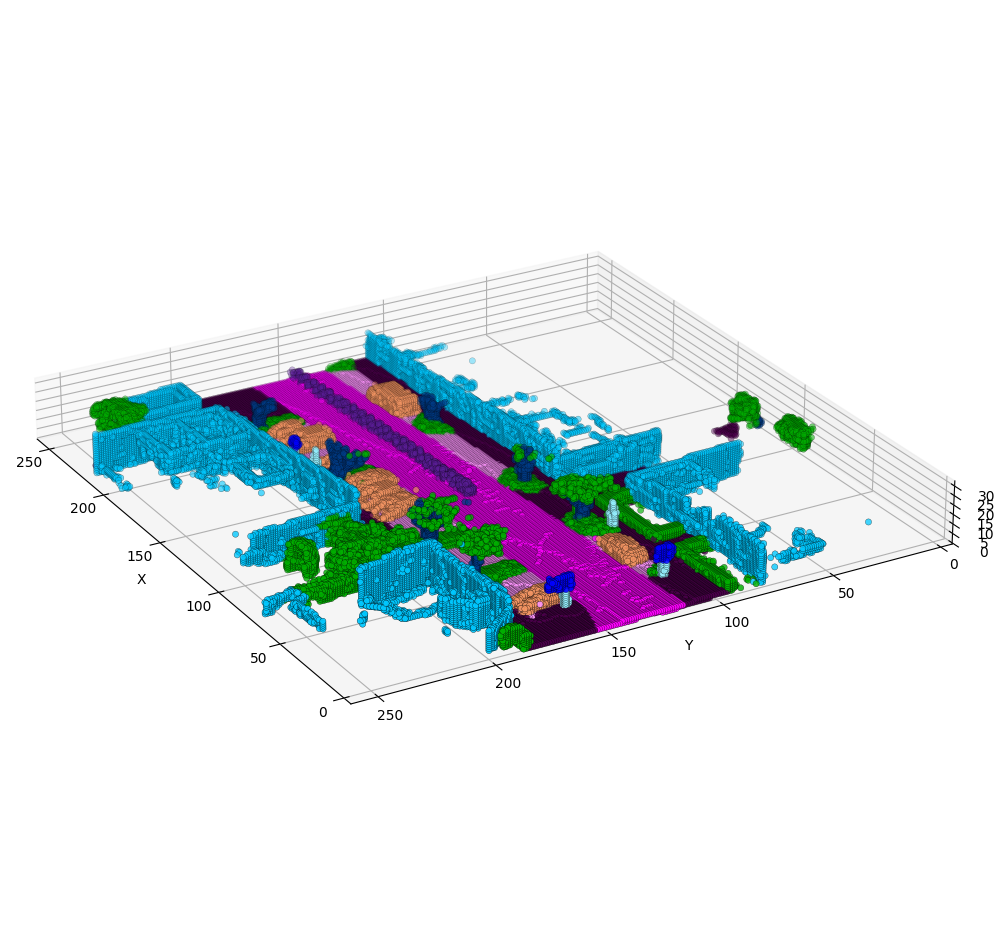

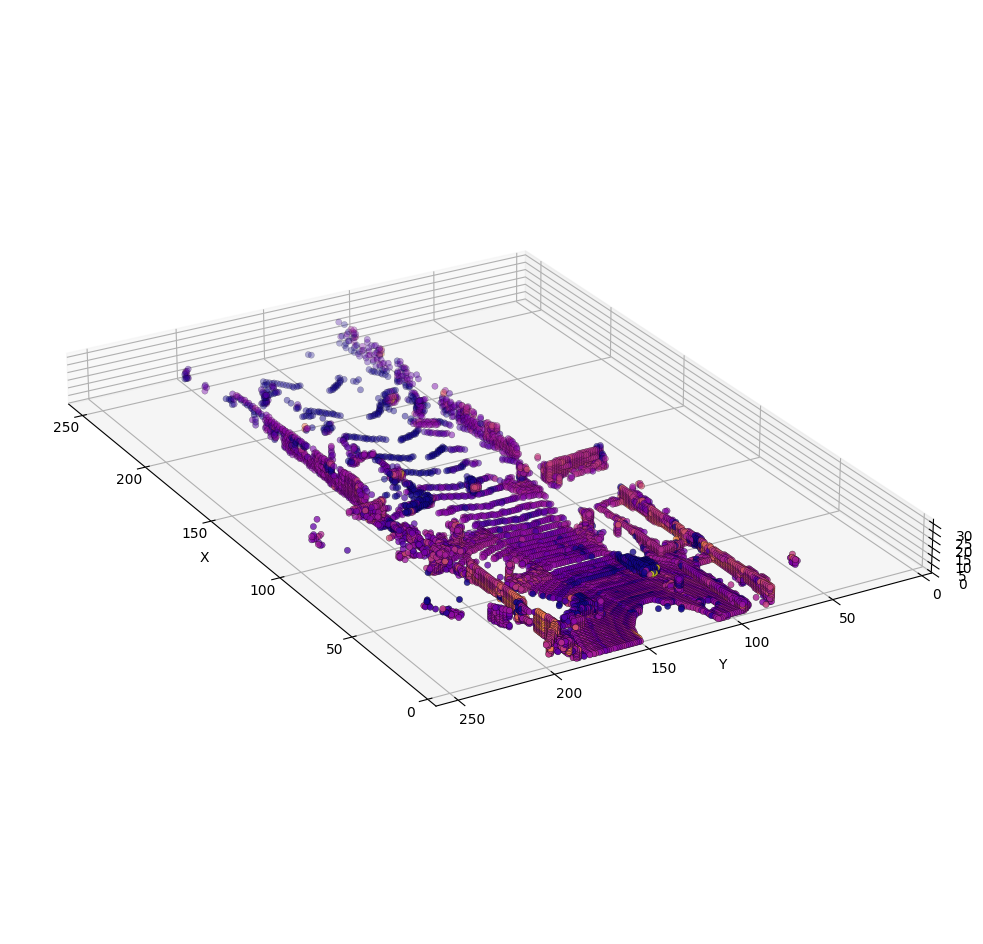

unique:  tensor([  0.,   1.,   5.,   8.,   9.,  10.,  11.,  13.,  14.,  15.,  16.,  18.,
         19., 255.], device='cuda:0')


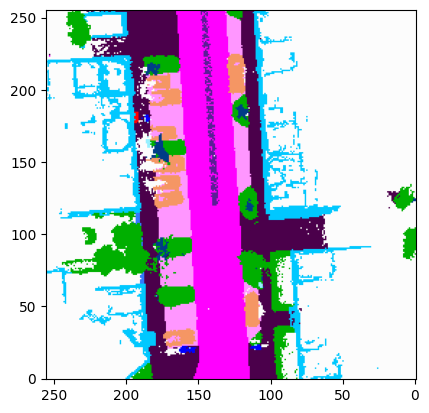

In [11]:
level = "256"
input2d = collect(complet_inputs, "input2d")
bev_labels = collect(complet_inputs, "bev_labels")

gt_labels = collect(complet_inputs, "complet_labels_{}".format(level))
gt_labels = np.uint32(gt_labels.detach().cpu().numpy())
invalid = gt_labels==255
coords = collect(complet_inputs, "complet_coords").squeeze()
complet_features = collect(complet_inputs, "complet_features")
print(complet_features.shape)
print(coords.shape)


coords_np = coords[:,:].detach().cpu().numpy()
coords_np = coords_np.astype(int)
voxels = np.zeros((1,256,256,32))
# voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=np.int32(complet_features.detach().cpu().numpy()[0]*10.0)
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2],coords_np[:,3]]=(np.uint8(complet_features[0].detach().cpu().numpy()*126.0)+1.0)
plot_3d_voxels(gt_labels[0], level)
plot_3d_voxels(voxels[0], level, input=True)
# plot_2d_input(input2d[0])
print("unique: ", torch.unique(bev_labels))

plot_bev(bev_labels[0])
# plot_3d_voxels(gt_labels[1], level)
# plot_3d_voxels(voxels[1], level,input=True)


In [17]:
import k3d


# plot_3d_pointcloud(seg_coords[0],seg_labels[0])

seg_labels_np = np.uint32(seg_labels.detach().cpu().numpy())
seg_coords_np = np.float32(seg_coords.detach().cpu().numpy())
seg_coords_np = seg_coords_np[:,1:]
seg_coords_np = seg_coords_np[seg_labels_np<100]
seg_labels_np = seg_labels_np[seg_labels_np<100]+1
print(seg_coords_np.shape)
print(seg_labels_np.shape)
print(np.unique(seg_labels_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.points(seg_coords_np, attribute=seg_labels_np,point_size=1,shader="dot",cmap=color_map)
plot += plt_points
plot.display()


(95801, 3)
(95801,)
[ 1  8  9 10 11 13 14 15 16 17 18 19]


Output()

## 2D UNet model